In [4]:
import yfinance as yf
from auxillary import *
from indicators import *
from datetime import date
from processData import processData
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import gc

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense


In [34]:
stocks = []
print("Enter the ticker symbols of interest (enter spacebar to exit)")
s = "  "
while s != " ":
    s = input("Ticker: ")
    if s == " " and len(stocks) == 0:
        print("Please enter a ticker symbol")
        s = "  "
        continue
    elif s == " ":
        break
    if s.upper() not in stocks:
        stocks.append(s.upper())

Enter the ticker symbols of interest (enter spacebar to exit)


In [38]:
prices, general, target, cluster, pc = processData(stocks[0], n)

In [ ]:
# RNN LSTM

## Initial attempt at model

In [67]:
variables = ["Close","OBV_ROC_Percentile", "MACD_ROC_Percentile"]
training_set = pd.concat([prices, general], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], len(variables))))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=25,batch_size=32)

X_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))
result = model.evaluate(X_test)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)

real_stock_price = prices.iloc[-len(X_test):, 3:4].values

results = model.evaluate(X_test, y_sc.transform(real_stock_price))

Epoch 1/25
57/57 [==============================] - 22s 120ms/step - loss: 0.0059
Epoch 2/25
57/57 [==============================] - 7s 129ms/step - loss: 0.0013
Epoch 3/25
57/57 [==============================] - 7s 123ms/step - loss: 0.0011
Epoch 4/25
57/57 [==============================] - 9s 150ms/step - loss: 9.5401e-04
Epoch 5/25
57/57 [==============================] - 8s 142ms/step - loss: 9.5046e-04
Epoch 6/25
57/57 [==============================] - 7s 125ms/step - loss: 9.9029e-04
Epoch 7/25
57/57 [==============================] - 7s 126ms/step - loss: 0.0010
Epoch 8/25
57/57 [==============================] - 7s 121ms/step - loss: 9.1473e-04
Epoch 9/25
57/57 [==============================] - 7s 122ms/step - loss: 7.9715e-04
Epoch 10/25
57/57 [==============================] - 7s 127ms/step - loss: 7.2283e-04
Epoch 11/25
57/57 [==============================] - 7s 120ms/step - loss: 8.9404e-04
Epoch 12/25
57/57 [==============================] - 7s 123ms/step - loss: 8.2

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

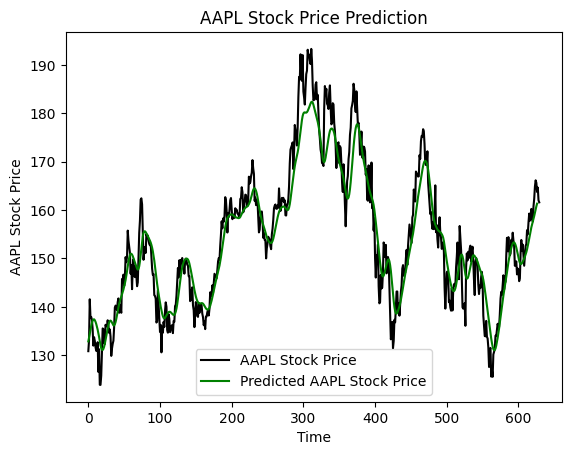

In [71]:
plt.plot(real_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [188]:
def buildRNN(num_layers, num_neurons, input_shape, lr):
    model = Sequential()
    model.add(LSTM(units=num_neurons,return_sequences=True,input_shape= input_shape))
    model.add(Dropout(0.2))
    
    i = 2
    while i <= n_layers:
            
        if i == n_layers:
            model.add(LSTM(units=50))
        else:
            model.add(LSTM(units=50,return_sequences=True))
        model.add(Dropout(0.2))
        i+=1

    model.add(Dense(units=1))
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),loss='mean_squared_error')
    return model

## Split Data into 5 Folds for CV

In [ ]:
variables = ["Close","OBV_ROC_Percentile", "MACD_ROC_Percentile"]
training_set = pd.concat([prices, general], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

from sklearn.preprocessing import MinMaxScaler
x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)

train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

trainX, valX = cvSplit(X_train, 5)
trainY, valY = cvSplit(y_train, 5)


## Tune Number of LTSM layers using CV split

In [78]:
layers = []
layer_loss = []

for n_layers in range(2,7):
    result_loss = 0
    for k in range(len(trainX)):
        X_train_ = trainX[k]
        X_val_ = valX[k]
        y_train_ = trainY[k]
        y_val_ = valY[k]

        model = buildRNN(n_layers, 50, (X_train_.shape[1], len(variables)), 0.001)
    
        model.fit(X_train_,y_train_,epochs=25,batch_size=32)

        results = model.evaluate(X_val_, y_val_)

        result_loss += results

    result_loss = result_loss / 5
    layers.append(n_layers)
    layer_loss.append(result_loss)


Epoch 1/25
12/12 [==============================] - 9s 61ms/step - loss: 0.0018
Epoch 2/25
12/12 [==============================] - 1s 63ms/step - loss: 7.6861e-04
Epoch 3/25
12/12 [==============================] - 1s 60ms/step - loss: 5.4022e-04
Epoch 4/25
12/12 [==============================] - 1s 72ms/step - loss: 3.1524e-04
Epoch 5/25
12/12 [==============================] - 1s 56ms/step - loss: 2.1509e-04
Epoch 6/25
12/12 [==============================] - 1s 67ms/step - loss: 1.5360e-04
Epoch 7/25
12/12 [==============================] - 1s 74ms/step - loss: 1.3103e-04
Epoch 8/25
12/12 [==============================] - 1s 78ms/step - loss: 1.3936e-04
Epoch 9/25
12/12 [==============================] - 1s 74ms/step - loss: 9.8005e-05
Epoch 10/25
12/12 [==============================] - 1s 63ms/step - loss: 8.0060e-05
Epoch 11/25
12/12 [==============================] - 1s 107ms/step - loss: 9.1364e-05
Epoch 12/25
12/12 [==============================] - 1s 58ms/step - loss: 9.3

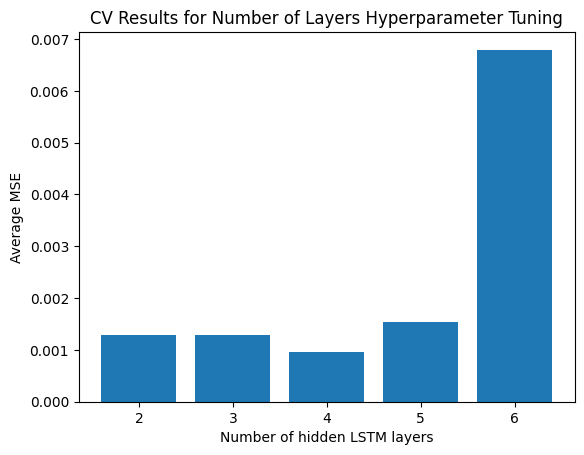

In [138]:
plt.bar(x = layers, height = layer_loss)
plt.title("CV Results for Number of Layers Hyperparameter Tuning")
plt.xlabel("Number of hidden LSTM layers")
plt.ylabel("Average MSE")
plt.show()

## Tune number of neurons

In [83]:
neurons = [10, 25, 50, 75, 100]
neurons_loss = []

for n_neurons in neurons:
    result_loss = 0
    for k in range(len(trainX)):
        X_train_ = trainX[k]
        X_val_ = valX[k]
        y_train_ = trainY[k]
        y_val_ = valY[k]

        model = buildRNN(4, n_neurons, (X_train_.shape[1], len(variables)), 0.001)
    
        model.fit(X_train_,y_train_,epochs=25,batch_size=32)   
        
        results = model.evaluate(X_val_, y_val_)

        result_loss += results

    result_loss = result_loss / 5

    neurons_loss.append(result_loss)

Epoch 1/25
12/12 [==============================] - 20s 95ms/step - loss: 0.0027
Epoch 2/25
12/12 [==============================] - 1s 96ms/step - loss: 9.6282e-04
Epoch 3/25
12/12 [==============================] - 1s 96ms/step - loss: 7.3679e-04
Epoch 4/25
12/12 [==============================] - 1s 97ms/step - loss: 6.4127e-04
Epoch 5/25
12/12 [==============================] - 1s 95ms/step - loss: 6.7704e-04
Epoch 6/25
12/12 [==============================] - 1s 95ms/step - loss: 6.4381e-04
Epoch 7/25
12/12 [==============================] - 1s 96ms/step - loss: 6.1776e-04
Epoch 8/25
12/12 [==============================] - 1s 94ms/step - loss: 5.8455e-04
Epoch 9/25
12/12 [==============================] - 1s 96ms/step - loss: 6.0170e-04
Epoch 10/25
12/12 [==============================] - 1s 95ms/step - loss: 5.9489e-04
Epoch 11/25
12/12 [==============================] - 1s 94ms/step - loss: 5.6825e-04
Epoch 12/25
12/12 [==============================] - 1s 96ms/step - loss: 5.2

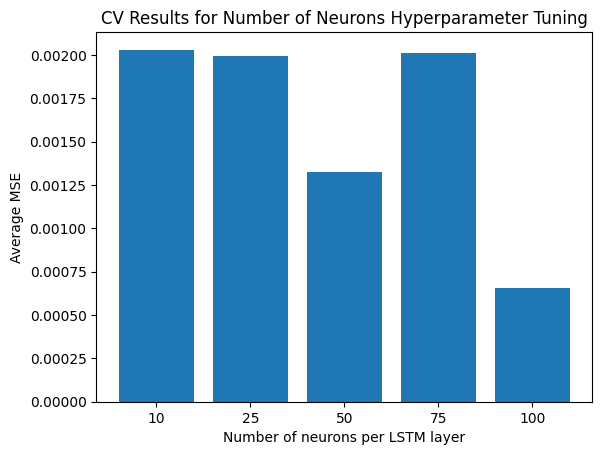

In [146]:
neurons_str = ["10", "25", '50', '75', '100']
plt.bar(x = neurons_str, height = neurons_loss)
plt.title("CV Results for Number of Neurons Hyperparameter Tuning")
plt.xlabel("Number of neurons per LSTM layer")
plt.ylabel("Average MSE")
plt.show()

## Tune Learning Rate Using CV 

In [87]:
from keras import optimizers

rates = [0.001, 0.005, 0.01, 0.05, 1]
rates_loss = []

for lr in rates:
    result_loss = 0
    for k in range(len(trainX)):
        X_train_ = trainX[k]
        X_val_ = valX[k]
        y_train_ = trainY[k]
        y_val_ = valY[k]

        model = buildRNN(4, 50, (X_train_.shape[1], len(variables)), lr)
    
        model.fit(X_train_,y_train_,epochs=25,batch_size=32)   
        
        results = model.evaluate(X_val_, y_val_)

        result_loss += results

    result_loss = result_loss / len(trainX)

    rates_loss.append(result_loss)

Epoch 1/25


c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


12/12 [==============================] - 16s 138ms/step - loss: 0.0011
Epoch 2/25
12/12 [==============================] - 2s 136ms/step - loss: 5.9176e-04
Epoch 3/25
12/12 [==============================] - 2s 141ms/step - loss: 4.5164e-04
Epoch 4/25
12/12 [==============================] - 2s 135ms/step - loss: 2.0185e-04
Epoch 5/25
12/12 [==============================] - 2s 139ms/step - loss: 1.2045e-04
Epoch 6/25
12/12 [==============================] - 2s 134ms/step - loss: 1.1376e-04
Epoch 7/25
12/12 [==============================] - 2s 136ms/step - loss: 1.1696e-04
Epoch 8/25
12/12 [==============================] - 2s 138ms/step - loss: 9.6347e-05
Epoch 9/25
12/12 [==============================] - 2s 183ms/step - loss: 7.6892e-05
Epoch 10/25
12/12 [==============================] - 4s 305ms/step - loss: 9.5017e-05
Epoch 11/25
12/12 [==============================] - 3s 273ms/step - loss: 8.5886e-05
Epoch 12/25
12/12 [==============================] - 4s 325ms/step - loss: 9.

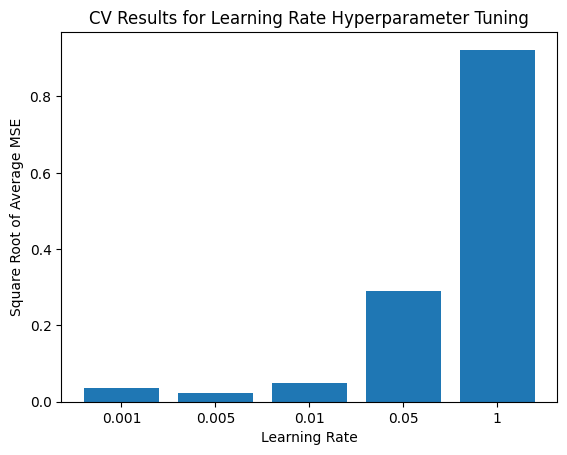

In [151]:
rates_str = ["0.001", "0.005", '0.01', '0.05', '1']
plt.bar(x = rates_str, height = np.sqrt(rates_loss))
plt.title("CV Results for Learning Rate Hyperparameter Tuning")
plt.xlabel("Learning Rate")
plt.ylabel("Square Root of Average MSE")
plt.show()
# 0.005 minimizes loss

Tuned parameters are: Learning rate - 0.005, LSTM layers - 4, Neurons per layer - 100

In [122]:
# Vanilla model

variables = ["Close"]
training_set = pd.concat([prices, general], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = buildRNN(4, 100, (X_train.shape[1], len(variables)), 0.005)

model.fit(X_train,y_train,epochs=25,batch_size=32)

real_stock_price = prices.iloc[int(0.75*len(prices)):, 3:4].values

X_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))
result = model.evaluate(X_test)
predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)


Epoch 1/25
58/58 [==============================] - 66s 809ms/step - loss: 0.0127
Epoch 2/25
58/58 [==============================] - 44s 754ms/step - loss: 8.0670e-04
Epoch 3/25
58/58 [==============================] - 46s 791ms/step - loss: 7.2793e-04
Epoch 4/25
58/58 [==============================] - 45s 783ms/step - loss: 8.2300e-04
Epoch 5/25
58/58 [==============================] - 52s 898ms/step - loss: 7.5469e-04
Epoch 6/25
58/58 [==============================] - 43s 745ms/step - loss: 0.0018
Epoch 7/25
58/58 [==============================] - 45s 770ms/step - loss: 6.8098e-04
Epoch 8/25
58/58 [==============================] - 48s 827ms/step - loss: 5.2149e-04
Epoch 9/25
58/58 [==============================] - 45s 776ms/step - loss: 5.5756e-04
Epoch 10/25
58/58 [==============================] - 45s 774ms/step - loss: 4.2683e-04
Epoch 11/25
58/58 [==============================] - 44s 750ms/step - loss: 5.0737e-04
Epoch 12/25
58/58 [==============================] - 46s 787

In [123]:
results = model.evaluate(X_test, y_sc.transform(real_stock_price))
print(results)

20/20 [==============================] - 6s 148ms/step - loss: 0.0033
0.0032976355869323015


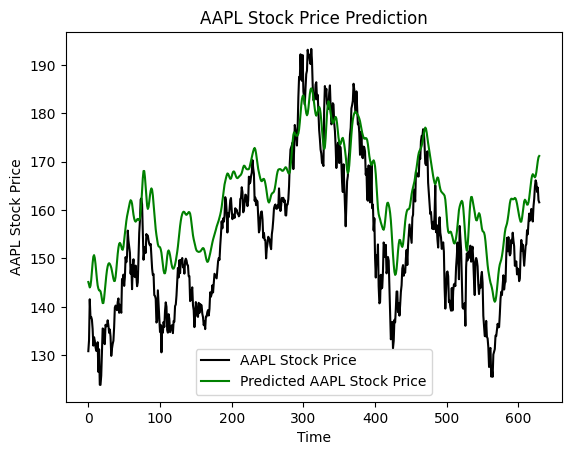

In [124]:
plt.plot(real_stock_price, color = 'black', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

## Add first two principal components to vanilla model

In [135]:
variables = ["Close", "PC0", "PC1"]
training_set = pd.concat([prices, general, pc], axis = 1).loc[:,variables].dropna().values
train_y = [row[0] for row in training_set]
train_y = np.array(train_y).reshape(-1,1)

x_sc = MinMaxScaler(feature_range=(0,1))
y_sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = x_sc.fit_transform(training_set)
train_y = y_sc.fit_transform(train_y)
X_train = []
y_train = []
for i in range(60, int(len(training_set_scaled)*0.75)):
    X_train.append(training_set_scaled[i-60:i, :])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

model = buildRNN(4,100, (X_train.shape[1], len(variables)), 0.005)

model.fit(X_train,y_train,epochs=25,batch_size=32)

X_test = []
y_test = []
for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
    X_test.append(training_set_scaled[i-60:i, :])
    y_test.append(training_set_scaled[i+10, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))

real_stock_price = prices.iloc[-len(X_test):, 3:4].values

predicted_stock_price = model.predict(X_test)
predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)


Epoch 1/25
56/56 [==============================] - 39s 391ms/step - loss: 0.0255
Epoch 2/25
56/56 [==============================] - 22s 392ms/step - loss: 0.0014
Epoch 3/25
56/56 [==============================] - 22s 384ms/step - loss: 0.0013
Epoch 4/25
56/56 [==============================] - 22s 389ms/step - loss: 0.0011
Epoch 5/25
56/56 [==============================] - 22s 392ms/step - loss: 0.0014
Epoch 6/25
56/56 [==============================] - 22s 401ms/step - loss: 0.0015
Epoch 7/25
56/56 [==============================] - 24s 420ms/step - loss: 0.0015
Epoch 8/25
56/56 [==============================] - 23s 408ms/step - loss: 0.0011
Epoch 9/25
56/56 [==============================] - 22s 387ms/step - loss: 0.0015
Epoch 10/25
56/56 [==============================] - 22s 401ms/step - loss: 0.0010
Epoch 11/25
56/56 [==============================] - 21s 376ms/step - loss: 9.3475e-04
Epoch 12/25
56/56 [==============================] - 21s 382ms/step - loss: 0.0012
Epoch 13/

In [136]:
results = model.evaluate(X_test, y_sc.transform(real_stock_price))
print(results)

19/19 [==============================] - 8s 146ms/step - loss: 0.0162
0.016162721440196037


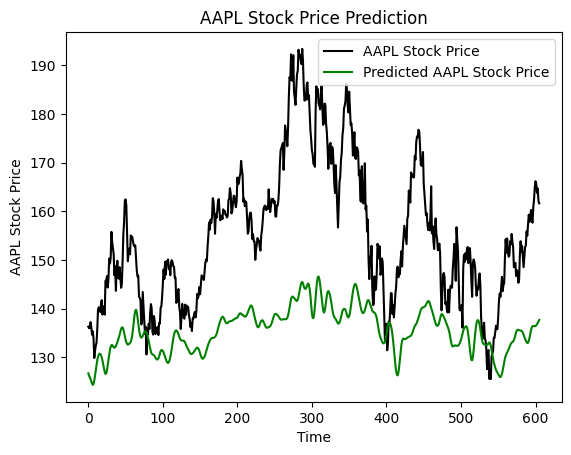

In [137]:
plt.plot(real_stock_price, color = 'black', label = 'AAPL Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted AAPL Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('AAPL Stock Price')
plt.legend()
plt.show()

In [187]:
stocks = []
print("Enter the ticker symbols of interest (enter spacebar to exit)")
s = "  "
while s != " ":
    s = input("Ticker: ")
    if s == " " and len(stocks) == 0:
        print("Please enter a ticker symbol")
        s = "  "
        continue
    elif s == " ":
        break
    if s.upper() not in stocks:
        stocks.append(s.upper())

for x in stocks:
    prices, general, target, cluster, pc = processData(x, n)
    variables = ["Close", "PC0", "PC1"]
    training_set = pd.concat([prices, general, pc], axis = 1).loc[:,variables].dropna().values
    train_y = [row[0] for row in training_set]
    train_y = np.array(train_y).reshape(-1,1)

    x_sc = MinMaxScaler(feature_range=(0,1))
    y_sc = MinMaxScaler(feature_range=(0,1))
    training_set_scaled = x_sc.fit_transform(training_set)
    train_y = y_sc.fit_transform(train_y)
    X_train = []
    y_train = []
    for i in range(60, int(len(training_set_scaled)*0.75)):
        X_train.append(training_set_scaled[i-60:i, :])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(variables)))

    model = buildRNN(4,100, (X_train.shape[1], len(variables)), 0.005)

    model.fit(X_train,y_train,epochs=25,batch_size=32)

    X_test = []
    y_test = []
    for i in range(int(len(training_set_scaled)*0.75), len(training_set_scaled)):
        X_test.append(training_set_scaled[i-60:i, :])
        y_test.append(training_set_scaled[i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(variables)))

    real_stock_price = prices.iloc[-len(X_test):, 3:4].values

    predicted_stock_price = model.predict(X_test)
    predicted_stock_price = y_sc.inverse_transform(predicted_stock_price)

    today = pd.concat([prices["Close"], pc.loc[:, ["PC0", "PC1"]]], axis = 1).iloc[-60:].values
    today_scaled = x_sc.transform(today)

    predicted_price = model.predict(np.array([today_scaled]))
    predicted_price = y_sc.inverse_transform(predicted_price)

    text = "Predicted price for " + x + ": $" + str(predicted_price[0])

    print(text)
    
    

Enter the ticker symbols of interest (enter spacebar to exit)
Epoch 1/25


c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


56/56 [==============================] - 40s 217ms/step - loss: 0.0708
Epoch 2/25
56/56 [==============================] - 12s 218ms/step - loss: 0.0060
Epoch 3/25
56/56 [==============================] - 12s 216ms/step - loss: 0.0045
Epoch 4/25
56/56 [==============================] - 12s 216ms/step - loss: 0.0048
Epoch 5/25
56/56 [==============================] - 12s 215ms/step - loss: 0.0041
Epoch 6/25
56/56 [==============================] - 13s 226ms/step - loss: 0.0036
Epoch 7/25
56/56 [==============================] - 12s 220ms/step - loss: 0.0044
Epoch 8/25
56/56 [==============================] - 12s 215ms/step - loss: 0.0036
Epoch 9/25
56/56 [==============================] - 12s 219ms/step - loss: 0.0027
Epoch 10/25
56/56 [==============================] - 12s 215ms/step - loss: 0.0026
Epoch 11/25
56/56 [==============================] - 12s 215ms/step - loss: 0.0026
Epoch 12/25
56/56 [==============================] - 12s 215ms/step - loss: 0.0028
Epoch 13/25
56/56 [=====

c:\Users\gmandl\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


56/56 [==============================] - 39s 236ms/step - loss: 0.0965
Epoch 2/25
56/56 [==============================] - 14s 249ms/step - loss: 0.0097
Epoch 3/25
56/56 [==============================] - 13s 238ms/step - loss: 0.0080
Epoch 4/25
56/56 [==============================] - 15s 265ms/step - loss: 0.0065
Epoch 5/25
56/56 [==============================] - 14s 255ms/step - loss: 0.0057
Epoch 6/25
56/56 [==============================] - 15s 264ms/step - loss: 0.0050
Epoch 7/25
56/56 [==============================] - 14s 254ms/step - loss: 0.0042
Epoch 8/25
56/56 [==============================] - 14s 246ms/step - loss: 0.0044
Epoch 9/25
56/56 [==============================] - 16s 279ms/step - loss: 0.0042
Epoch 10/25
56/56 [==============================] - 17s 301ms/step - loss: 0.0035
Epoch 11/25
56/56 [==============================] - 16s 286ms/step - loss: 0.0038
Epoch 12/25
56/56 [==============================] - 13s 230ms/step - loss: 0.0031
Epoch 13/25
56/56 [=====